In [60]:
import random as python_random

from matplotlib import pyplot as plt
plt.style.use('ggplot')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15/1.6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

import numpy as np
import pandas as pd

import talib

import yfinance as yf

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras import layers
from sklearn.preprocessing import MinMaxScaler

In [61]:
def MAPE(y_hat,y_pred):
    mape = (np.mean(np.abs((y_hat - y_pred)/y_hat)))*100
    return mape

def RMSE(y_hat,y_pred):
    MSE = np.square(np.subtract(y_hat,y_pred)).mean() 
    return (MSE**(1/2))


In [62]:
phys_dev=tf.config.list_physical_devices("GPU")
if len(phys_dev)!=0:
    tf.config.experimental.set_memory_growth(phys_dev[0],True)    
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')),"\n","Tensorflow version: ", tf.__version__)

Num GPUs Available:  1 
 Tensorflow version:  2.4.1


In [152]:
#PARAMETERS
EPOCHS=100
BATCH_SIZE=256
RANDOMSEED=123

np.random.seed(RANDOMSEED)
python_random.seed(RANDOMSEED)
tf.random.set_seed(RANDOMSEED)

gme=yf.Ticker('GME').history(start='2010-01-01',end='2021-01-01')
msft=yf.Ticker('MSFT').history(start='2010-01-01',end='2021-01-01')

In [153]:
class Dataset():
    def __init__(self, data,name, target='Close',timeseries=True,scale=True,look_forw=1,look_back=60,test_size=0.2,technical_indi=False, derived=False,only_w_timeseries=True):
    #Store the raw data.    
        self.name=name
        self.split=int(len(data)*(1-test_size))
        self.Scaler=None
        self.target_col=data.columns.get_loc(target)
        self.look_forw = look_forw
        self.look_back=look_back 
        self.train_dates=data.iloc[:self.split,:].index
        self.test_dates=data.iloc[self.split-self.look_back:,:].index

        #self.Data=data.dropna(subset=['Close'],how='any')   
        if technical_indi==True:
            data['SMA']=talib.SMA(data.Close,10)
            data['EMA']=talib.EMA(data.Close,10)
            data['MOM']=talib.MOM(data.Close,10)
            data['MACD']=talib.MACD(data.Close, fastperiod=12, slowperiod=26, signalperiod=9)[0]
            data['RSI']=talib.RSI(data.Close,14)
            
            if only_w_timeseries:
                self.data=data.drop(['High','Open','Low','Dividends','Stock Splits'],axis=1).iloc[33:,:]
            else:
                self.data=data.iloc[33:,:]
                
        if derived==True:
            data['S&P500']=yf.Ticker('^GSPC').history(start='2010-01-01',end='2021-01-01').Close
            data['VIX']=yf.Ticker('^VIX').history(start='2010-01-01',end='2021-01-01').Close
            
            if only_w_timeseries:
                self.data=data.drop(['High','Open','Low','Dividends','Stock Splits'],axis=1)
            else:
                self.data=data
                
        self.Train = np.array(self.data.iloc[:self.split,:])
        self.Test = np.array(self.data.iloc[self.split-self.look_back:,:])

        if timeseries==True:
            self.Train=self.Train[:,self.target_col].reshape(-1,1)
            self.Test=self.Test[:,self.target_col].reshape(-1,1)  
        
        if scale==True:
            self.Scaler=MinMaxScaler(feature_range = (-1, 1))
            self.Scaler=self.Scaler.fit(self.Train)
        
            self.Train=self.Scaler.transform(self.Train)
            self.Test=self.Scaler.transform(self.Test)
        
        self.X_train_seq=[]
        self.y_train_seq=[]
        for i in range(self.look_back,len(self.Train)):
            self.X_train_seq.append(self.Train[i-self.look_back:i,:])
                
            if timeseries==True:
                self.y_train_seq.append(self.Train[i:i+self.look_forw])
            else:
                self.y_train_seq.append(self.Train[i:i+self.look_forw,self.target_col])

        self.X_train_seq=np.array(self.X_train_seq).astype('float32')
        self.y_train_seq=np.array(self.y_train_seq,dtype='object').astype('float32')

        self.X_train_seq=self.X_train_seq.reshape(self.X_train_seq.shape[0],self.X_train_seq.shape[1],self.X_train_seq.shape[2])

        self.X_test_seq=[]
        for i in range(self.look_back,len(self.Test)):
                self.X_test_seq.append(self.Test[i-self.look_back:i,:])
                
        self.X_test_seq=np.asarray(self.X_test_seq).astype('float32')
        self.X_test_seq=self.X_test_seq.reshape(self.X_test_seq.shape[0],self.X_test_seq.shape[1],self.X_test_seq.shape[2])

    def __repr__(self):
        return self.name
    def __str__(self):
        return '\n'.join([
        f'Original train and test{self.Train.shape,self.Test.shape}',
        f'X train size {self.X_train_seq.shape}',
        f'Y train size: {self.y_train_seq.shape}',
        f'X test size: {self.X_test_seq.shape}'])

In [154]:
gme_data=Dataset(gme,name='GME',look_back=60,timeseries=False,scale=True,derived=True)
msft_data=Dataset(msft,name='MSFT',look_back=60,timeseries=False,scale=True,derived=True)
input_shape=(gme_data.look_back,gme_data.X_train_seq.shape[2])

In [155]:
gme_data.data.head(5)

,Close,Volume,S&P500,VIX
Date,,,,
2009-12-31,14.772204,2141800,1115.099976,21.680000
2010-01-04,15.418571,6675700,1132.989990,20.040001
2010-01-05,15.836020,5317400,1136.520020,19.350000
2010-01-06,16.179401,5367800,1137.140015,19.160000
2010-01-07,13.775718,41190300,1141.689941,19.059999


In [158]:
all_res={}
out_activations_list=['relu','linear']
activations_list=['swish','gelu']
dropout=[0,0.2,0.8]

In [159]:
es=EarlyStopping(monitor='val_loss',min_delta=1e-2,mode="min",patience=5,verbose=1)
initializer = tf.keras.initializers.LecunNormal()
regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)

In [162]:
for data in [gme_data,msft_data]:
    param_res={}
    for out_act in out_activations_list:
        for func in activations_list:
            for prob in dropout: 
                keras.backend.clear_session()
                opt_lstm = Sequential([ 
                    layers.LSTM(units=50, return_sequences=True,input_shape=input_shape,activation=func),
                    layers.Dropout(prob),
                    layers.LSTM(units=50, return_sequences=False),
                    layers.Dropout(prob),
                    layers.Dense(units=1,activation=out_act)
                ])    
                optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
                opt_lstm.compile(optimizer=optimizer,loss=['mse'],metrics=['accuracy'])
                opt_history=opt_lstm.fit(data.X_train_seq,data.y_train_seq,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                verbose=0,
                                validation_split=0.1,
                                callbacks=[es]
                                )
                
                preds_scaled=opt_lstm.predict(data.X_test_seq)
                preds=data.Scaler.inverse_transform(np.repeat(preds_scaled,data.Train.shape[1],axis=1))[:,0]
                    
                print(f'for {data.name}: {out_act} for output layer, {func} for LSTM layers with {prob} are done')
                opt_preds=preds
                param_res[f'{func} and {out_act} act. function and {prob} dropout']=opt_preds
    all_res[data.name]=param_res

Epoch 00006: early stopping
for GME: relu for output layer, swish for LSTM layers with 0 are done
Epoch 00006: early stopping
for GME: relu for output layer, swish for LSTM layers with 0.2 are done
Epoch 00006: early stopping
for GME: relu for output layer, swish for LSTM layers with 0.8 are done
Epoch 00006: early stopping
for GME: relu for output layer, gelu for LSTM layers with 0 are done
Epoch 00006: early stopping
for GME: relu for output layer, gelu for LSTM layers with 0.2 are done
Epoch 00006: early stopping
for GME: relu for output layer, gelu for LSTM layers with 0.8 are done
Epoch 00008: early stopping
for GME: linear for output layer, swish for LSTM layers with 0 are done
Epoch 00008: early stopping
for GME: linear for output layer, swish for LSTM layers with 0.2 are done
Epoch 00009: early stopping
for GME: linear for output layer, swish for LSTM layers with 0.8 are done
Epoch 00008: early stopping
for GME: linear for output layer, gelu for LSTM layers with 0 are done
Epoc

<AxesSubplot:title={'center':'RMSE scores for LSTM model'}>

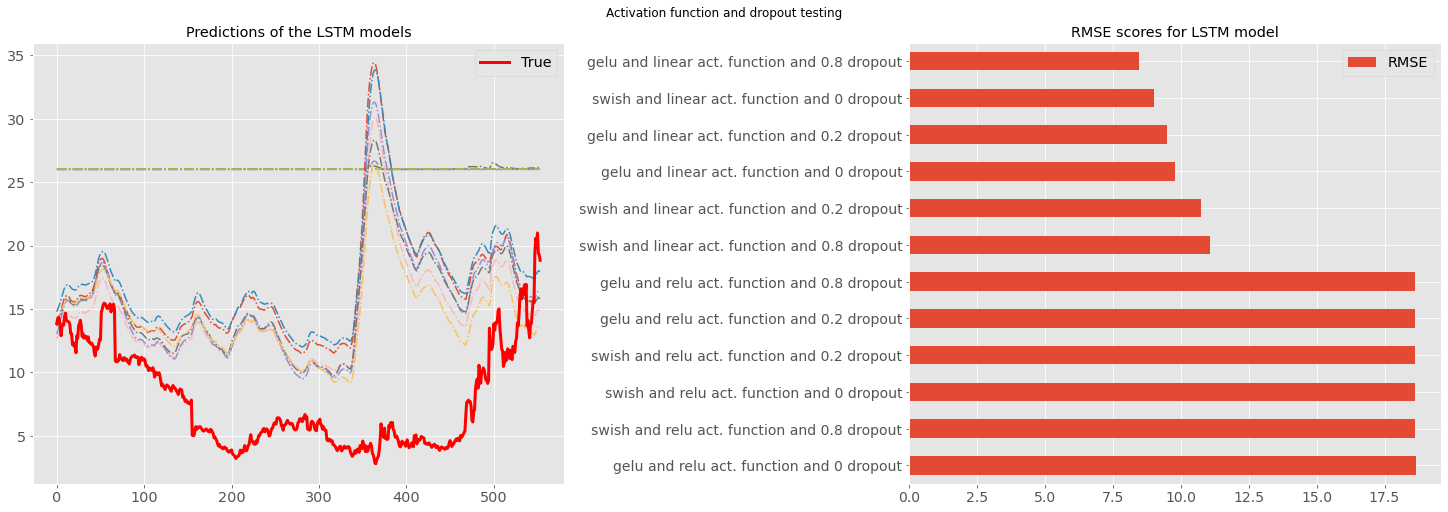

In [163]:
results_df=pd.DataFrame()
for key in all_res['GME'].keys():
    res=RMSE(gme.Close[gme_data.split:].values.reshape(-1,1),all_res['GME'][key])
    results_df.loc[0,key]=res   

fig, axs = plt.subplots(1,2,figsize=(20,7), constrained_layout=True)
fig.suptitle('Activation function and dropout testing')

for key in all_res['GME'].keys():
    axs = axs.flatten()
    axs[0].plot(all_res['GME'][key],'-.',linewidth=1.5)
axs[0].plot(gme.Close[gme_data.split:].values.reshape(-1,1),'r',linewidth=3,label='True')
axs[0].title.set_text('Predictions of the LSTM models')
axs[0].legend()
axs[1].title.set_text('RMSE scores for LSTM model')
results_df.rename(index={0: "RMSE"}).T.sort_values(ascending=False,by='RMSE')[:].plot.barh(ax=axs[1],fontsize=14)

(0.0, 100.0)

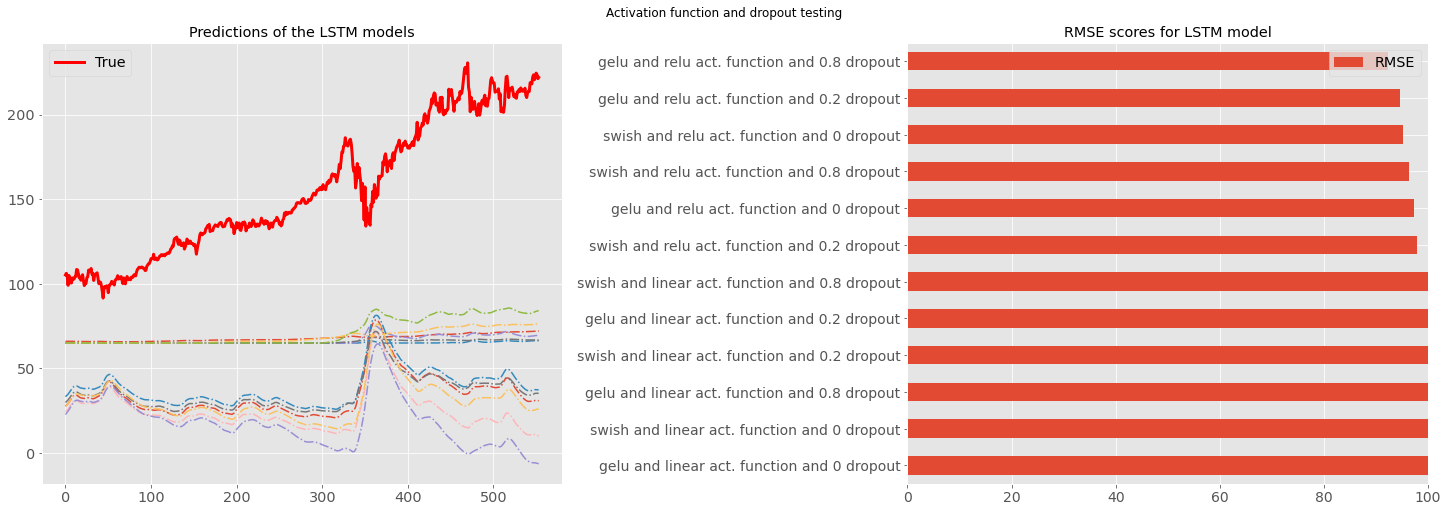

In [164]:
results_df=pd.DataFrame()
for key in all_res['MSFT'].keys():
    res=RMSE(msft.Close[msft_data.split:].values.reshape(-1,1),all_res['MSFT'][key])
    results_df.loc[0,key]=res   

fig, axs = plt.subplots(1,2,figsize=(20,7), constrained_layout=True)
fig.suptitle('Activation function and dropout testing')

for key in all_res['MSFT'].keys():
    axs = axs.flatten()
    axs[0].plot(all_res['MSFT'][key],'-.',linewidth=1.5)
axs[0].plot(msft.Close[msft_data.split:].values.reshape(-1,1),'r',linewidth=3,label='True')
axs[0].title.set_text('Predictions of the LSTM models')
axs[0].legend()
axs[1].title.set_text('RMSE scores for LSTM model')
axs[1]=results_df.rename(index={0: 'RMSE'}).T.sort_values(ascending=False,by='RMSE')[:].plot.barh(ax=axs[1],fontsize=14) 
axs[1].set_xlim(0,100)